### Company XYZ is an online grocery store. In the current version of the website, they have manually grouped the items into a few categories based on their experience. However, they now have a lot of data about user purchase history. Therefore, they would like to put the data into use! This is what they asked you to do:

#### (1) The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:
##### the customer who bought the most items overall in her lifetime
##### for each item, the customer who bought that product the most
#### (2) Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

### Load the package would be used

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex, colorConverter

from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette


%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Read in the data set

In [2]:
purchase = pd.read_csv("../Datasets/grocery/purchase_history.csv")
item = pd.read_csv("../Datasets/grocery/item_to_id.csv")

### Look into dataset

In [3]:
print(purchase.shape)
print(item.shape)

print(purchase.head)
print(item.head)

print(purchase.info)
print(item.info)

print(len(purchase["user_id"]) == len(pd.unique(purchase["user_id"])))
print(len(item["Item_id"]) == len(pd.unique(item["Item_id"])))

(39474, 2)
(48, 2)
<bound method NDFrame.head of        user_id                                                 id
0       222087                                              27,26
1      1343649                                            6,47,17
2       404134                       18,12,23,22,27,43,38,20,35,1
3      1110200                                 9,23,2,20,26,47,37
4       224107  31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4...
...        ...                                                ...
39469   704794                                      48,42,44,10,2
39470    31237              23,21,26,27,41,9,47,43,20,40,16,24,46
39471   724925              3,39,28,4,1,43,47,27,18,25,44,10,30,2
39472   651509                           13,39,20,32,37,1,3,18,34
39473   517744                    39,40,20,3,10,42,38,43,28,25,13

[39474 rows x 2 columns]>
<bound method NDFrame.head of             Item_name  Item_id
0              coffee       43
1                 tea       23
2        

### Data Processing

#### Step 1: Separate the item of purchase history to multiple columns (up to total number of items)

In [4]:
print(len(pd.unique(item["Item_id"])))
print(sorted(item["Item_id"].unique()))

48
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [5]:
purchase_split = purchase["id"].str.split(",", n = 48, expand = True)
purchase_split["user_id"] = purchase["user_id"]
purchase_split = purchase_split.reset_index()
purchase_split.head()

,index,0,1,2,3,...,23,24,25,26,user_id
0,0,27,26,None,None,...,None,None,None,None,222087
1,1,6,47,17,None,...,None,None,None,None,1343649
2,2,18,12,23,22,...,None,None,None,None,404134
3,3,9,23,2,20,...,None,None,None,None,1110200
4,4,31,18,5,13,...,None,None,None,None,224107


#### Step 2: Convert the wide-format purchase history to long-format purchase history, and then remove missing values

In [6]:
purchase_long = pd.melt(purchase_split, id_vars = ["index", "user_id"], value_vars = purchase_split.columns[1:28])[["user_id", "value"]]
purchase_long = purchase_long[["user_id", "value"]].dropna()
purchase_long.head()

,user_id,value
0,222087,27
1,1343649,6
2,404134,18
3,1110200,9
4,224107,31


#### (1) The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:

##### the customer who bought the most items overall in her lifetime

In [7]:
##### Method 1:
grp_user1 = purchase_long[["user_id", "value"]].groupby("user_id").count().reset_index()
print(grp_user1.sort_values(by = ["value"], ascending = False)[0:3])

##### Method 2:
purchase_split["total_item"] = purchase_split.drop(columns = ["index", "user_id"]).count(axis = "columns")
grp_user2 = purchase_split[["user_id", "total_item"]].groupby(["user_id"]).sum().reset_index()
print(grp_user2.sort_values(by = ["total_item"], ascending = False)[0:3])

      user_id  value
4445   269335     72
6111   367872     70
6623   397623     64
      user_id  total_item
4445   269335          72
6111   367872          70
6623   397623          64


##### for each item, the customer who bought that product the most

In [8]:
grp_item = purchase_long.reset_index().groupby(["value", "user_id"]).count().reset_index()
max_item = grp_item[["value", "index"]].groupby("value").max().reset_index().merge(grp_item, on = ["value", "index"], how = "left")
max_item = max_item.rename(columns = {"value": "Item_id", "index": "count"})
max_item["Item_id"] = max_item["Item_id"].astype(str)
item["Item_id"] = item["Item_id"].astype(str)
max_item_name = max_item.merge(item, on = "Item_id", how = "left")[0:10]
print(max_item_name[0:10])

  Item_id  count  user_id Item_name
0       1      4    31625     sugar
1       1      4    68836     sugar
2       1      4   540483     sugar
3       1      4  1091637     sugar
4       1      4  1301034     sugar
5      10      4   618914   carrots
6      10      4   743501   carrots
7      10      4  1485538   carrots
8      11      3   367872   cereals
9      11      3   534745   cereals


#### (2) Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

In [9]:
purchase_long = purchase_long.rename(columns = {"value": "Item_id"})
purchase_long["Item_id"] = purchase_long["Item_id"].astype(str)
purchase_long_name = purchase_long.merge(item, on = "Item_id", how = "left")
purchase_name = pd.crosstab(purchase_long_name.user_id, purchase_long_name.Item_name, margins = False).reset_index()
purchase_name = purchase_name.drop(columns = "user_id")

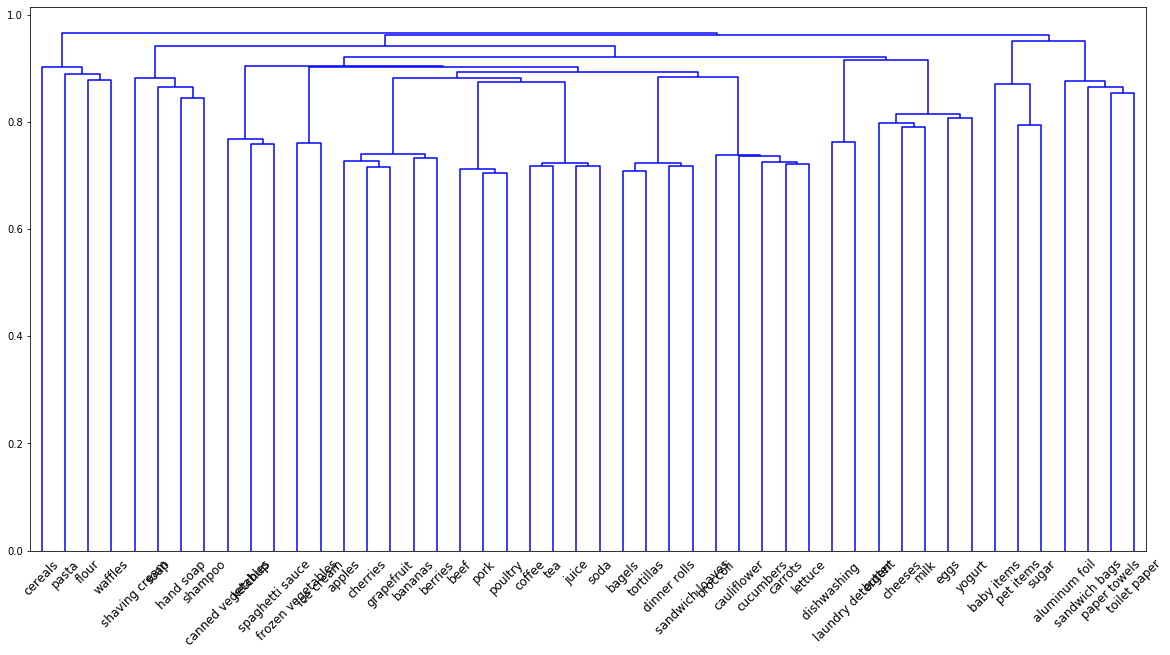

In [10]:
purchase_name_t = purchase_name.transpose()
c_dist = pdist(purchase_name_t)
c_link = linkage(purchase_name_t, metric = "correlation", method = "complete")
plt.figure(figsize = (20, 10))
B = dendrogram(c_link, labels = list(purchase_name.columns), leaf_rotation = 45., leaf_font_size = 12.)

In [11]:
#### Reference: http://datanongrata.com/2019/04/27/67/

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

def get_clust_graph(df, numclust, transpose=False, dataname=None, save=False, xticksize=8):
    if transpose==True:
        aml=df.transpose()
        xl="x-axis"
    else:
        aml=df
        xl="y-axis"
    data_dist = pdist(aml.transpose()) # computing the distance
    data_link = linkage(data_dist,  metric='correlation', method='complete')#method="complete") # computing the linkage
    B=dendrogram(data_link,labels=list(aml.columns),p=numclust, truncate_mode="lastp",get_leaves=True, count_sort='ascending', show_contracted=True)
    #myInd = [i for i, c in zip(B['ivl'], B['color_list']) if c=='g']
    get_cluster_classes(B)
    ax=plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=xticksize)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.xlabel(xl)
    #plt.set_size_inches(18.5, 10.5)
    plt.ylabel('Distance')
    plt.suptitle(xl+" clustering for "+dataname, fontweight='bold', fontsize=16);
    if save:
        plt.savefig(str(df.index.name)+str(numclust)+"tr_"+str(transpose)+"dn_"+str(dataname)+save+'.png')
    else:
        print("Not saving")
    return get_cluster_classes(B)

def give_cluster_assigns(df, numclust, tranpose=True):
    if transpose==True:
        data_dist = pdist(df.transpose())
        data_link = linkage(data_dist,  metric='correlation', method='complete')
        cluster_assigns=pd.Series(sch.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.columns)
    else:
        data_dist = pdist(df)
        data_link = linkage(data_dist,  metric='correlation', method='complete')
        cluster_assigns=pd.Series(sch.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.index)
    for i in arange(1,numclust+1):
        print("Cluster ",str(i),": ( N =",len(cluster_assigns[cluster_assigns==i].index),")", ", ".join(list(cluster_assigns[cluster_assigns==i].index)))

Not saving


b,"['bananas', 'grapefruit', 'apples', 'berries', 'cherries', 'carrots', 'cauliflower', 'cucumbers', 'broccoli', 'bagels', 'tortillas', 'dinner rolls', 'sandwich loaves', 'pork', 'poultry', 'beef', 'coffee', 'tea', 'juice', 'soda', 'pet items', 'sugar', 'lettuce']"
g,"['ketchup', 'spaghetti sauce', 'canned vegetables']"
r,"['dishwashing\xa0', 'laundry detergent']"
c,"['frozen vegetables', 'ice cream']"
m,"['milk', 'yogurt', 'paper towels', 'toilet paper', 'sandwich bags', 'aluminum foil', 'hand soap', 'shampoo', 'soap', 'shaving cream', 'flour', 'pasta', 'cereals', 'waffles', 'baby items', 'cheeses', 'butter', 'eggs']"


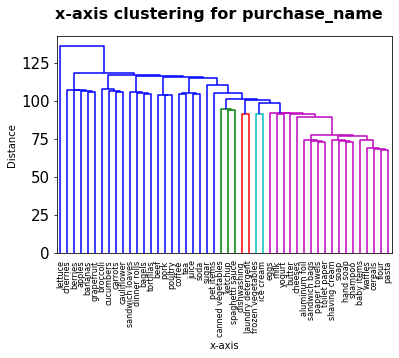

In [12]:
get_clust_graph(purchase_name_t, 193, transpose = True, dataname = "purchase_name")